In [1]:
import math
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import style
import matplotlib
import time
import scanpy as sc
import sklearn
import networkx as nx
import ot
import paste as pst
from paste.helper import to_dense_array
import anndata

In [6]:
def mapping_accuracy(labels1,labels2,pi):
    mapping_dict = {'Layer1':1, 'Layer2':2, 'Layer3':3, 'Layer4':4, 'Layer5':5, 'Layer6':6, 'WM':7}
    return np.sum(pi*(scipy.spatial.distance_matrix(np.matrix(labels1.map(mapping_dict) ).T,np.matrix(labels2.map(mapping_dict)).T)==0))

def mapping_accuracy_per_layer(labels1,labels2,pi):
    return {layer:np.sum(pi*np.array(np.matrix(labels1==layer,dtype=int).T.dot(np.matrix(labels2==layer,dtype=int)))) for layer in ['Layer{0}'.format(i) for i in range(1,7)]+['WM']}

In [2]:
sample_list = ["151507", "151508", "151509","151510", "151669", "151670","151671", "151672", "151673","151674", "151675", "151676"]
adatas = {sample:sc.read_h5ad('../data/DLPFC/{0}_preprocessed.h5'.format(sample)) for sample in sample_list}
sample_groups = [["151507", "151508", "151509","151510"],[ "151669", "151670","151671", "151672"],[ "151673","151674", "151675", "151676"]]
layer_groups = [[adatas[sample_groups[j][i]] for i in range(len(sample_groups[j]))] for j in range(len(sample_groups))]
layer_to_color_map = {'Layer{0}'.format(i+1):sns.color_palette()[i] for i in range(6)}
layer_to_color_map['WM'] = sns.color_palette()[6]

In [4]:
for j in range(len(layer_groups)): 
    for i in range(len(layer_groups[j])):
        print(j,i)
        temp_counts = pd.read_csv("../data/DLPFC/{}_tissue_spot_counts.csv".format(sample_list[j*4+i]),index_col=0)
        temp_idx = layer_groups[j][i].obs.index.copy().map(lambda x: x.split('.')[0])
        temp_counts = temp_counts.loc[temp_idx]
        layer_groups[j][i].obs['cell_count'] = np.maximum(np.array(temp_counts['count'],dtype=int),1)
        temp_stat = layer_groups[j][i].obs.groupby('layer_guess_reordered')['cell_count'].agg(['count','sum'])
        temp_stat['avg_cells']=temp_stat['sum']/temp_stat['count']
        print(temp_stat)
        temp_stat = (temp_stat/temp_stat.sum(axis=0)).rename(columns={'sum':'cell count','count':'layer count'})
        temp_stat['diff'] = temp_stat['layer count']-temp_stat['cell count']
        print(temp_stat)

0 0
                       count   sum  avg_cells
layer_guess_reordered                        
Layer1                   817  1085   1.328029
Layer2                   305   473   1.550820
Layer3                  1215  2489   2.048560
Layer4                   369  1006   2.726287
Layer5                   674  1976   2.931751
Layer6                   486  1599   3.290123
WM                       354  1670   4.717514
                       layer count  cell count  avg_cells      diff
layer_guess_reordered                                              
Layer1                    0.193602    0.105360   0.071426  0.088242
Layer2                    0.072275    0.045931   0.083408  0.026344
Layer3                    0.287915    0.241697   0.110179  0.046217
Layer4                    0.087441    0.097689   0.146629 -0.010248
Layer5                    0.159716    0.191882   0.157680 -0.032166
Layer6                    0.115166    0.155273   0.176954 -0.040107
WM                        0.083886    

In [7]:
alpha = 0.1
pis_with_cells = [[None for i in range(len(layer_groups[j])-1)] for j in range(len(layer_groups))]
for j in range(len(layer_groups)):
    for i in range(len(layer_groups[j])-1):
        print(j,i)
        a_distribution = np.array(layer_groups[j][i].obs['cell_count']/sum(layer_groups[j][i].obs['cell_count']))
        b_distribution = np.array(layer_groups[j][i+1].obs['cell_count']/sum(layer_groups[j][i+1].obs['cell_count']))
        pi0=np.loadtxt('../data/DLPFC/saved_results/init_{0}_{1}_{2}.gz'.format(j,i,'ot'), delimiter=',')
        start = time.time()
        pis_with_cells[j][i] = pst.pairwise_align(layer_groups[j][i], layer_groups[j][i+1],alpha=alpha, a_distribution = a_distribution, b_distribution = b_distribution,G_init=pi0,norm=True,verbose=False)
        tt = time.time()-start
        acc = mapping_accuracy(layer_groups[j][i].obs['layer_guess_reordered'],layer_groups[j][i+1].obs['layer_guess_reordered'],pis_with_cells[j][i])
        print('Accuracy',acc,'time',tt)

0 0
Filtered all slices for common genes. There are 9219 common genes.


/Users/alexanderstrzalkowski/.pyenv/versions/3.8.3/lib/python3.8/site-packages/ot/lp/__init__.py:276: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


Accuracy 0.711758808877025 time 127.75248503684998
0 1
Filtered all slices for common genes. There are 9248 common genes.


/Users/alexanderstrzalkowski/.pyenv/versions/3.8.3/lib/python3.8/site-packages/ot/lp/__init__.py:276: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


Accuracy 0.15713935654558833 time 125.46994972229004
0 2
Filtered all slices for common genes. There are 10032 common genes.


/Users/alexanderstrzalkowski/.pyenv/versions/3.8.3/lib/python3.8/site-packages/ot/lp/__init__.py:276: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


Accuracy 0.7053012454328064 time 108.74441194534302
1 0
Filtered all slices for common genes. There are 9915 common genes.


/Users/alexanderstrzalkowski/.pyenv/versions/3.8.3/lib/python3.8/site-packages/ot/lp/__init__.py:276: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


Accuracy 0.9150107359740264 time 16.663379907608032
1 1
Filtered all slices for common genes. There are 9965 common genes.


/Users/alexanderstrzalkowski/.pyenv/versions/3.8.3/lib/python3.8/site-packages/ot/lp/__init__.py:276: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


Accuracy 0.5919535439415383 time 19.496335983276367
1 2
Filtered all slices for common genes. There are 10543 common genes.


/Users/alexanderstrzalkowski/.pyenv/versions/3.8.3/lib/python3.8/site-packages/ot/lp/__init__.py:276: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


Accuracy 0.8547483805009282 time 375.3860821723938
2 0
Filtered all slices for common genes. There are 11373 common genes.


/Users/alexanderstrzalkowski/.pyenv/versions/3.8.3/lib/python3.8/site-packages/ot/lp/__init__.py:276: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


Accuracy 0.6411975488073554 time 215.49228715896606
2 1
Filtered all slices for common genes. There are 10629 common genes.


/Users/alexanderstrzalkowski/.pyenv/versions/3.8.3/lib/python3.8/site-packages/ot/lp/__init__.py:276: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


Accuracy 0.7656910243699107 time 175.1365840435028
2 2
Filtered all slices for common genes. There are 10493 common genes.


/Users/alexanderstrzalkowski/.pyenv/versions/3.8.3/lib/python3.8/site-packages/ot/lp/__init__.py:276: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


Accuracy 0.7699027933852826 time 74.70582008361816


In [10]:
new_layer_groups = [pst.stack_slices_pairwise(layer_groups[j], pis_with_cells[j]) for j in range(len(layer_groups))]

In order to run the cell below it is necessary to have ran the notebook `DLPFC_pairwise.ipynb` first to generate the pairwise pis.

In [12]:
pis = [[None for i in range(len(layer_groups[j])-1)] for j in range(len(layer_groups))]
for j in range(len(layer_groups)):
    for i in range(len(layer_groups[j])-1):
        pis[j][i]=np.loadtxt('../data/DLPFC/saved_results/init_{0}_{1}_{2}.gz'.format(j,i,"ot"), delimiter=',')

In [14]:
sample_map,pair_map = {0:'I',1:'II',2:'III'},{0:'AB',1:'BC',2:'CD'}
comaprison_df = pd.DataFrame(columns=['Sample','Pair','Distribution','Layer','Accuracy'])
for j in range(len(layer_groups)):
    for i in range(len(layer_groups[j])-1):
        for dist,aligns in [('Uniform',pis),('Cell_Count',pis_with_cells)]:
            accs = mapping_accuracy_per_layer(layer_groups[j][i].obs['layer_guess_reordered'],layer_groups[j][i+1].obs['layer_guess_reordered'],aligns[j][i])            
            for layer in accs:
                comaprison_df.loc[len(comaprison_df)] = [sample_map[j],pair_map[i],dist,layer,accs[layer]]
comaprison_df

,Sample,Pair,Distribution,Layer,Accuracy
0,I,AB,Uniform,Layer1,0.180743
1,I,AB,Uniform,Layer2,0.041323
2,I,AB,Uniform,Layer3,0.274730
3,I,AB,Uniform,Layer4,0.060049
4,I,AB,Uniform,Layer5,0.133307
...,...,...,...,...,...
121,III,CD,Cell_Count,Layer3,0.101312
122,III,CD,Cell_Count,Layer4,0.026579
123,III,CD,Cell_Count,Layer5,0.117293
124,III,CD,Cell_Count,Layer6,0.101950


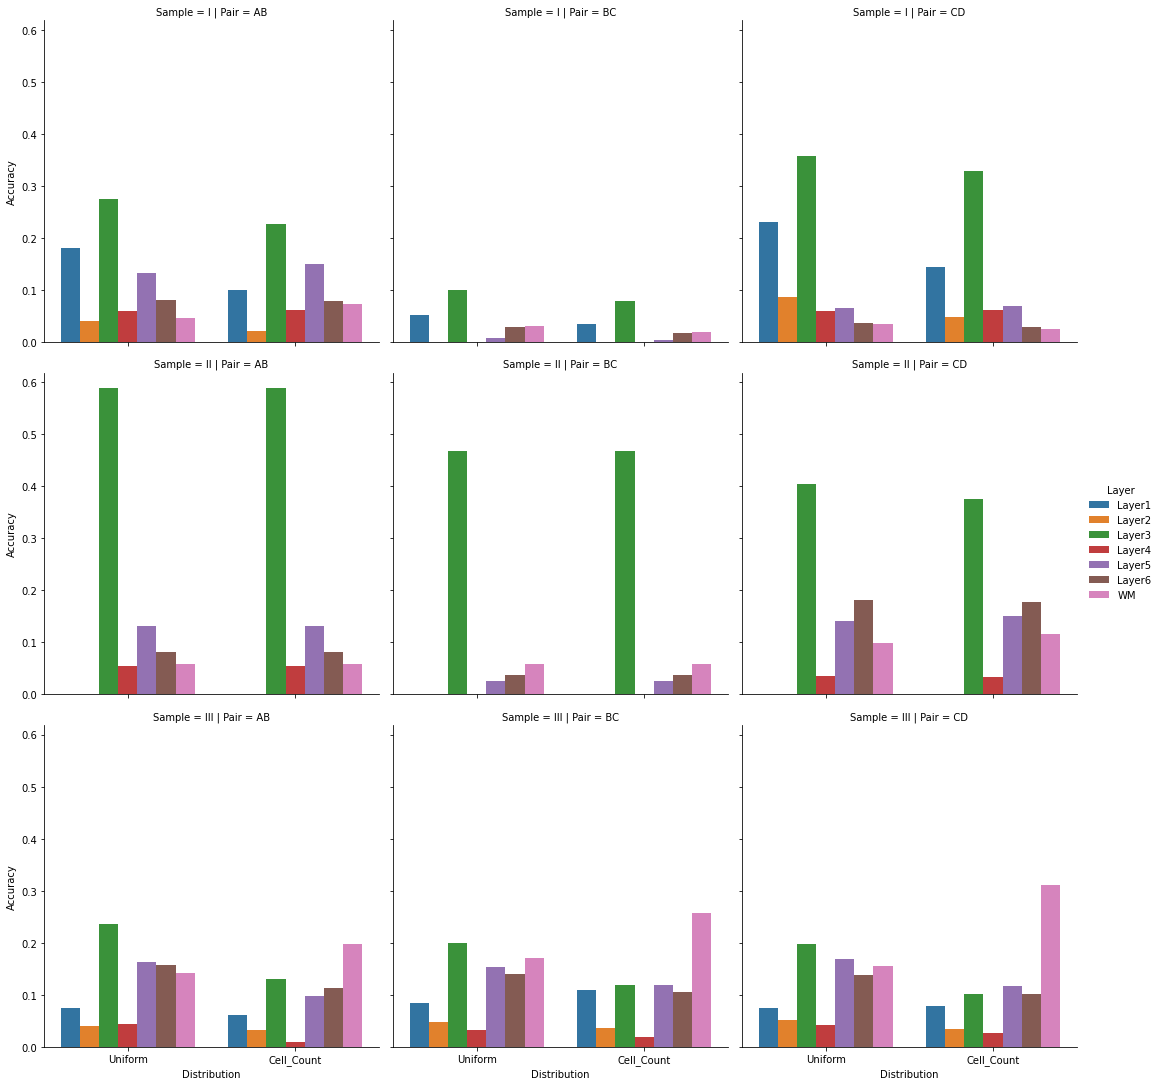

In [15]:
g = sns.catplot(x="Distribution", y="Accuracy",hue='Layer',row='Sample', col="Pair",data=comaprison_df,kind="bar", ci=None, aspect=1,legend=True)

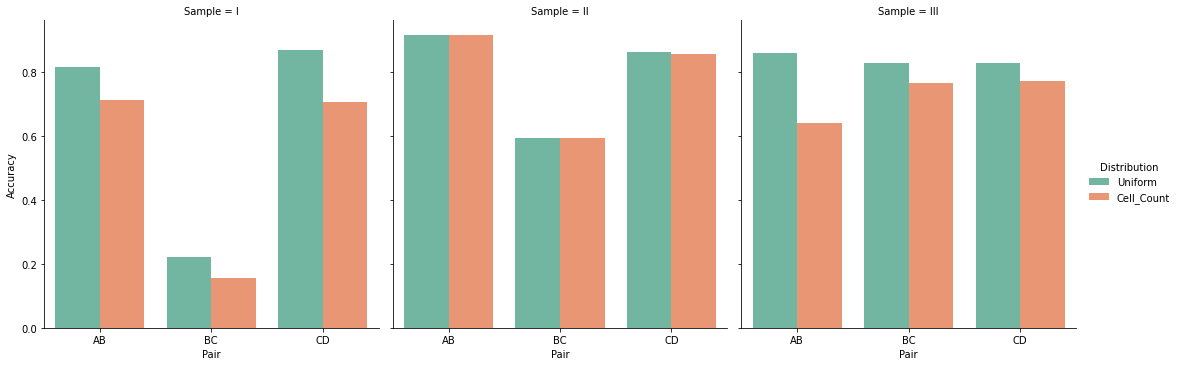

In [16]:
g = sns.catplot(x="Pair", y="Accuracy", hue='Distribution', col="Sample",data=comaprison_df.groupby(['Sample','Pair','Distribution'])['Accuracy'].agg('sum').reset_index(),kind="bar", ci=None, aspect=1,legend=True,hue_order=['Uniform','Cell_Count'],palette='Set2')